# Global Temperature Change Analysis
We analize the annual global mean temperature anomalies provided by the [Goddard Institute for Space Studies (GISS)](https://data.giss.nasa.gov/gistemp/). The [dataset](https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv) is available for download as CSV file from the GISS website.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


In [53]:
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
ds_path = 'data/GLB.Ts+dSST.csv'
giss_temp = pd.read_csv(ds_path, header=1)
giss_temp.tail(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
142,2022,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86
143,2023,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41


In [54]:
year_index = pd.date_range('1880', '2024', freq='Y')
#giss_temp.drop(giss_temp.tail(1).index,inplace=True)
#giss_temp['Dec'] = pd.to_numeric(giss_temp['Dec'])
giss_temp.set_index(year_index, inplace=True)
giss_temp.drop('Year', axis=1, inplace=True)
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19


In [55]:
annual_mean = []
for index, row in giss_temp.iterrows():
    sum = 0
    months = 0
    for col in giss_temp.columns[0:12]:
        sum += row[col]  
    annual_mean.append(round(sum / 12, 2))

In [56]:
giss_temp['Annual Mean'] = annual_mean
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17


## Uncertainty
The uncertainty is provided in an additional [file](https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv) available from the [GISS](https://data.giss.nasa.gov/gistemp/graphs_v4/) website

In [57]:
url_error_data = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv'
error_data = pd.read_csv(url_error_data)
error_data['ci95'].astype(float)
error = error_data['ci95']
error_data['ci95'] = error.apply(lambda error: round(error, 2)) 
error_data.tail(2)

,year,ci95
142,2022,0.05
143,2023,0.05


In [58]:
len(giss_temp)

144

In [59]:
giss_temp['Uncertainty'] = error_data['ci95'].tolist()
giss_temp['Uncertainty']
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean,Uncertainty
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89,0.05
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17,0.05


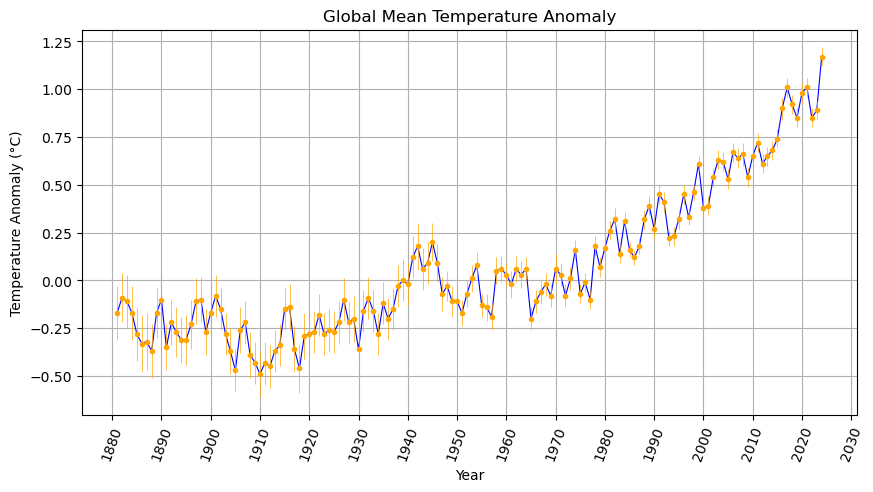

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Mean Temperature Anomaly')
ax.set_ylabel('Temperature Anomaly (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp.index)
ax.set_xticklabels(giss_temp.index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_giss_temp = ax.plot(giss_temp['Annual Mean'], linewidth=0.8, label='temp.anom', color='blue')
plt_giss_error= ax.errorbar(giss_temp.index, giss_temp['Annual Mean'], yerr=giss_temp['Uncertainty'], linewidth=0.5, color='orange', fmt='.k');
#plt.legend(loc='upper left')
plt.savefig('giss_anomaly.png', dpi=300)

In [9]:
ADF_result = adfuller(giss_temp['Annual Mean'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 1.4641340696516245
p-value: 0.9973868775709003


In [19]:
giss_temp_diff = np.diff(giss_temp['Annual Mean'], n=1)
giss_temp_diff_df = pd.DataFrame({'Diff': giss_temp_diff}, index=year_index[1:])

In [32]:
giss_temp_diff.size

143

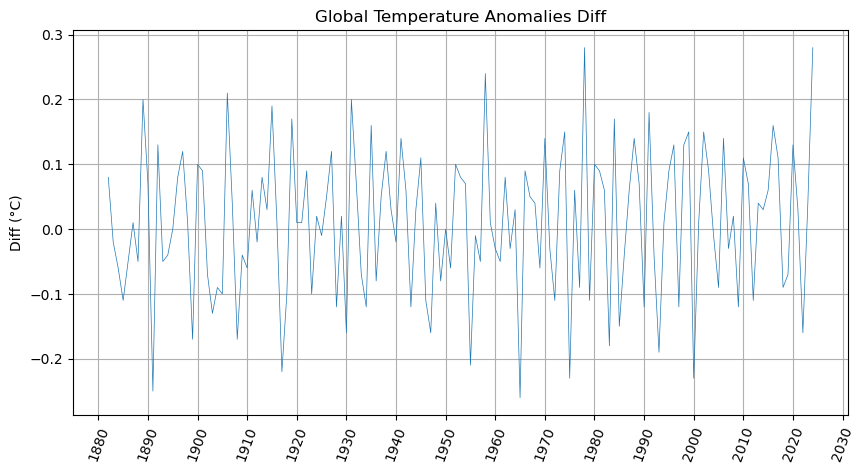

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Temperature Anomalies Diff')
ax.set_ylabel('Diff (°C)')
ax.set_xticks(giss_temp_diff_df.index)
ax.set_xticklabels(giss_temp_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_google_diff = ax.plot(giss_temp_diff_df, linewidth=0.5, label='anom.diff')
#plt.legend(loc='upper left')

In [12]:
ADF_result = adfuller(giss_temp_diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.562154289780749
p-value: 2.990356395695225e-11


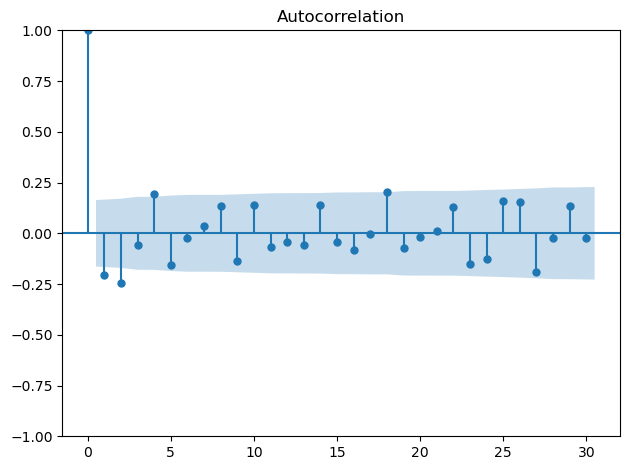

In [13]:
plot_acf(giss_temp_diff_df, lags=30)
plt.tight_layout()

In [14]:
train = giss_temp_diff_df[:int(0.9*len(giss_temp_diff_df))]
test = giss_temp_diff_df[int(0.9*len(giss_temp_diff_df)):]
print(len(train))
print(len(test))

128
15


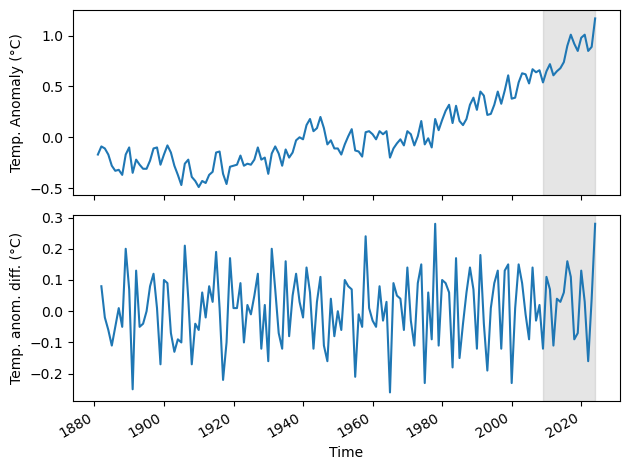

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(giss_temp['Annual Mean'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Temp. Anomaly (°C)')
ax1.axvspan('2008-12-31', '2023-12-31', color='#808080', alpha=0.2)

ax2.plot(giss_temp_diff_df['Diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Temp. anom. diff. (°C)')
ax2.axvspan('2008-12-31', '2023-12-31', color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

## Forecasts

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [40]:
pred_df = test.copy()
pred_df.size

15

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
print('Train: {0:d}\nHorizon: {1:d}'.format(TRAIN_LEN, HORIZON))

In [36]:
pred_mean = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [37]:
len(pred_mean)

16

In [42]:
pred_df['pred_mean'] = pred_mean[1:]
pred_df['pred_last_value'] = pred_last_value[1:]
pred_df['pred_MA'] = pred_MA[1:]

pred_df.head()

,Diff,pred_mean,pred_last_value,pred_MA
2009-12-31,0.11,0.005547,-0.12,0.020325
2010-12-31,0.07,0.006846,0.07,-0.047628
2011-12-31,-0.11,0.006846,0.07,-0.016812
2012-12-31,0.04,0.006212,0.04,0.000195
2013-12-31,0.03,0.006212,0.04,-0.006958


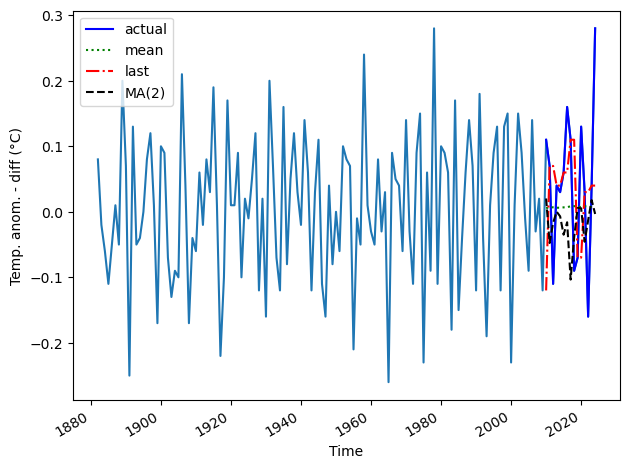

In [44]:
fig, ax = plt.subplots()

ax.plot(giss_temp_diff_df['Diff'])
ax.plot(pred_df['Diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Temp. anom. - diff (°C)')

#ax.axvspan(128, 143, color='#808080', alpha=0.2)

#ax.set_xlim(128, 143)

#plt.xticks([439, 468, 498], ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [61]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['Diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

0.013450456622488678 0.017939999999999998 0.016735238495552775


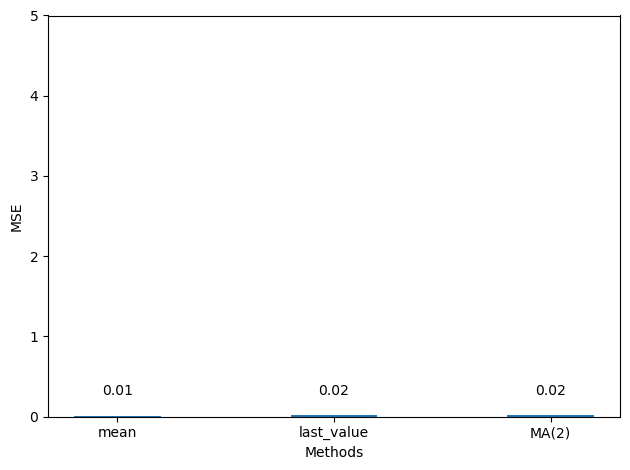

In [62]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [72]:
giss_temp['Prediction'] = pd.Series()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,...,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean,Uncertainty,Prediction
2009-12-31,0.64,0.53,0.54,0.61,0.65,0.64,0.73,0.69,0.71,0.66,...,0.67,0.66,.64,.57,0.60,0.69,0.72,0.65,0.04,NaN
2010-12-31,0.75,0.83,0.92,0.84,0.75,0.68,0.63,0.67,0.64,0.71,...,0.45,0.72,.74,.75,0.84,0.66,0.72,0.72,0.05,NaN
2011-12-31,0.52,0.48,0.65,0.65,0.53,0.62,0.70,0.75,0.56,0.66,...,0.60,0.61,.60,.48,0.61,0.69,0.60,0.61,0.05,NaN
2012-12-31,0.49,0.49,0.58,0.73,0.78,0.64,0.58,0.66,0.72,0.80,...,0.52,0.65,.65,.53,0.70,0.63,0.77,0.65,0.05,NaN
2013-12-31,0.71,0.62,0.67,0.54,0.61,0.69,0.60,0.70,0.76,0.69,...,0.70,0.68,.66,.62,0.60,0.66,0.76,0.68,0.05,NaN
2014-12-31,0.76,0.55,0.78,0.79,0.86,0.67,0.58,0.83,0.87,0.80,...,0.77,0.74,.74,.67,0.81,0.69,0.78,0.74,0.05,NaN
2015-12-31,0.86,0.90,0.96,0.76,0.80,0.81,0.73,0.79,0.85,1.09,...,1.16,0.90,.87,.84,0.84,0.78,1.00,0.90,0.06,NaN
2016-12-31,1.17,1.37,1.36,1.10,0.95,0.80,0.85,1.02,0.90,0.88,...,0.86,1.01,1.04,1.23,1.14,0.89,0.90,1.01,0.05,NaN
2017-12-31,1.02,1.14,1.16,0.94,0.91,0.72,0.82,0.87,0.77,0.90,...,0.93,0.92,.92,1.01,1.01,0.80,0.85,0.92,0.05,NaN
2018-12-31,0.82,0.85,0.88,0.89,0.82,0.77,0.82,0.77,0.80,1.01,...,0.91,0.85,.85,.86,0.86,0.79,0.88,0.85,0.05,NaN


In [76]:
giss_temp['Prediction'][129:] = giss_temp['Annual Mean'].iloc[129] + pred_df['pred_MA'].cumsum()

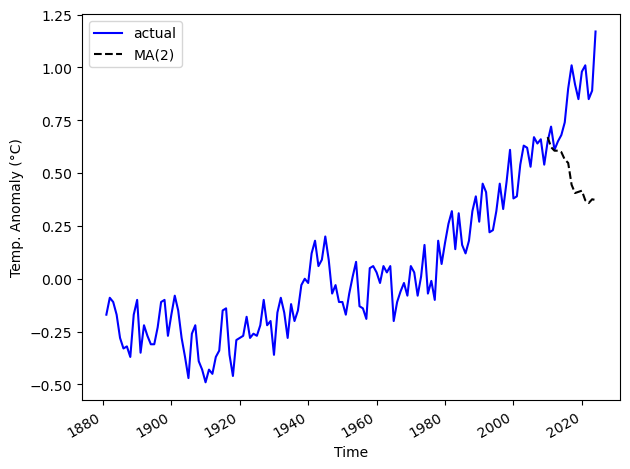

In [79]:
fig, ax = plt.subplots()

ax.plot(giss_temp['Annual Mean'], 'b-', label='actual')
ax.plot(giss_temp['Prediction'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Temp. Anomaly (°C)')

#ax.axvspan(129, 143, color='#808080', alpha=0.2)

#ax.set_xlim(100, 143)

#plt.xticks([409, 439, 468, 498], ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()